In [15]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from os import path
from mgefit.find_galaxy import find_galaxy
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord,ICRS
import astropy.constants as constants
from scipy.integrate import quad
import sympy as sp


对于同一个星系，画出地面望远镜（SDSS or DESI）和空间望远镜（Hubble）的（尽量同一波段）fits图像的对比

定出星系的中心（流量最高点）

• 计算其赤经赤纬


In [8]:
def pix2radec_legacy(x,y):
    xcen_ra_ip = y
    ycen_dec_ip = x
    file = './NGC1300_DESI_R.fits'
    f = fits.open(file)
    w = WCS(f[0].header)
    sky = w.pixel_to_world(xcen_ra_ip,ycen_dec_ip)   
    hmsdms = sky.to_string('hmsdms')
    ra = hmsdms.split(" ")[0]
    dec = hmsdms.split(" ")[1]
    print('ra,dec=',ra,dec) 


In [6]:
def pix2radec_Hubble(x,y):
    xcen_ra_ip = y
    ycen_dec_ip = x
    file = './NGC1300_f606w.fits'
    f = fits.open(file)
    w = WCS(f[1].header)
    sky = w.pixel_to_world(xcen_ra_ip,ycen_dec_ip)   
    hmsdms = sky.to_string('hmsdms')
    ra = hmsdms.split(" ")[0]
    dec = hmsdms.split(" ")[1]
    print('ra,dec=',ra,dec) 


 Pixels used: 15366
 Peak Img[j, k]: 400 400
 Mean (j, k): 399.26 399.04
 Theta (deg): 168.6
 Astro PA (deg): 101.4
 Eps: 0.437
 Major axis (pix): 98.8
ra,dec= 03h19m41.03669759s -19d24m40.05179998s


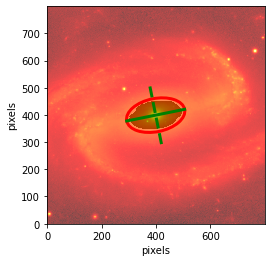

In [9]:
path = './NGC1300_DESI_R'
hdu_list = fits.open(path+'.fits', cache=True)
img = hdu_list[0].data
f = find_galaxy(img, fraction=0.03, plot=1)
xcen = f.xpeak
ycen = f.ypeak
pix2radec_legacy(xcen,ycen)

 Pixels used: 23147
 Peak Img[j, k]: 499 577
 Mean (j, k): 493.72 573.84
 Theta (deg): 178.2
 Astro PA (deg): 91.8
 Eps: 0.226
 Major axis (pix): 106.3
ra,dec= 03h19m41.0400642s -19d24m39.83864201s


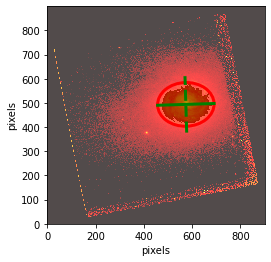

In [10]:
path = './NGC1300_f606w'
hdu_list = fits.open(path+'.fits', cache=True)
img = hdu_list[1].data
f = find_galaxy(img, fraction=0.03, plot=1)
xcen = f.xpeak
ycen = f.ypeak
pix2radec_Hubble(xcen,ycen)

In [ ]:
# 画在相同空间坐标系下才会更直观

1个本地（红移为0 ）重子物质为10^11 Msun的星系，
假设其物质密度分布为指数盘形式，指数盘的scalelength 为 3Kpc，该星系所在的暗物质晕的质量为
10^12Msun，暗物质的物质密度轮廓服从NFW分布
（c=10），该星系的运动为旋转的盘，请画出该星系的
旋转曲线

In [77]:
M_b = 1e11
M_dm = 1e12
l_scale = 3
G = constants.G


In [122]:
#计算暗物质profile
H = 0.06774*(u.km/u.s/u.kpc)#km/s/kpc
c= 10
M = (M_b+M_dm)*u.Msun
#Vc = 10*r200*H
#GM = 100*(r200**3)*H*2
#r200**3 = GM/(100*(H**2))

r200 = (G*M/(100*(H**2)))**(1/3)
rs = (r200/c).to_value(u.kpc)
print(r200.to_value(u.kpc))

delta0 = (200/3)*(c**3/(np.log(1+c)-(c/(1+c))))

def rou(r):
    return r**2*delta0/(r/rs*(1+r/rs)**2)
result, error = quad(rou, 0, 217)  

rou_crit = M_dm/(4*np.pi*result) 
#rou_r = rou_crit*delta0//((r/rs)*((1+r/rs)**2))

217.64789094791217


In [123]:
#计算重子物质profile
def f(r):
    return r*np.exp(-r/l_scale)
result, error = quad(f, 0, 217)  
I_b_0 = M_b/(2*np.pi*result) #Msun
#I_b(r) = I_b_0*np.exp(-r/l_scale)

In [131]:
G = constants.G
print(G)
print(G.to_value(((u.km)**3/u.Msun/(u.s)**2)))
G = 132712440000 *(u.km)**3/u.Msun/(u.s)**2
print(G)

  Name   = Gravitational constant
  Value  = 6.6743e-11
  Uncertainty  = 1.5e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2018
132712440000.0
132712440000.0 km3 / (s2 solMass)


In [142]:
def dm_density(r):
    return rou_crit*delta0/(r/rs)/(1+r/rs)**2
def bm_density(r):
    return I_b_0*np.exp(-r/l_scale)
def Mtot(r):
    return 4*np.pi*r**2*dm_density(r)+2*np.pi*r*bm_density(r)

bins = 2170
rmax = 217
Var = np.array([])
rar = np.array([])
for i in range(bins):
    r1 = i*rmax/bins
    M_1, error = quad(Mtot, 0, r1) 
    M_1 = M_1*u.Msun
    V = np.sqrt(G * M_1/(r1*u.kpc))
    Var = np.append(Var,V.to_value(u.km/u.s))
    rar = np.append(rar,r1)

    

<ipython-input-142-a1e48ea3a65e>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return rou_crit*delta0/(r/rs)/(1+r/rs)**2
<ipython-input-142-a1e48ea3a65e>:6: RuntimeWarning: invalid value encountered in scalar multiply
  return 4*np.pi*r**2*dm_density(r)+2*np.pi*r*bm_density(r)
<ipython-input-142-a1e48ea3a65e>:14: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  M_1, error = quad(Mtot, 0, r1)


Text(0, 0.5, 'V[km/s]')

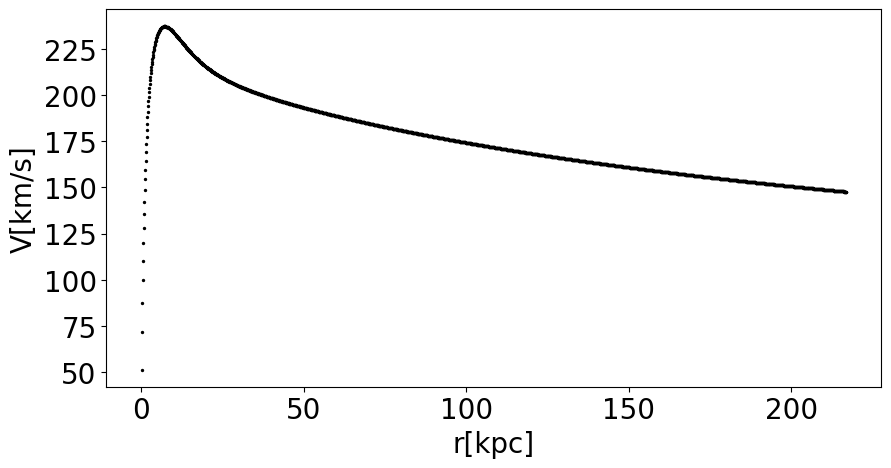

In [149]:
plt.figure(figsize=(10, 5),dpi=100) 
plt.scatter(rar,Var,c='k',s=2)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('r[kpc]',size=20)
plt.ylabel('V[km/s]',size=20)

In [ ]:
# 可以看一下各个不同的组分贡献的旋转速度分别是多少，盘不是三维的

对于Sersic指数分别是n=1，3，4的三个星系来说，其R90/R50分别是多少？

In [50]:
#设rscale = 5,且三个星系I0一致
rscale = 5
def n1(r):
    return 2*np.pi*r*np.exp(-(r/rscale)**(1/1))

All, error = quad(n1, 0, np.inf) 
print(All)
flag = 1
for i in range(200):
    I, error = quad(n1, 0, i) 
    if (I >=All*0.5)&(flag==1):
        r50 = i
        flag = 0    
        print(r50,flag)   
    if I >=All*0.9:
        r90 = i
        break
print(r90/r50)


157.07963267948776
9 0
2.2222222222222223


In [9]:
rscale = 5
def n3(r):
    return 2*np.pi*r*np.exp(-(r/rscale)**(1/3))

All, error = quad(n3, 0, np.inf) 
print(All)
flag = 1
for i in range(10000):
    I, error = quad(n3, 0, i) 
    if (I >=All*0.5)&(flag==1):
        r50 = i
        flag = 0      
    if I >=All*0.9:
        r90 = i
        break
print(r90/r50)


22619467.10584954
4.37353171495693


In [7]:

rscale = 5
def n4(r):
    return 2*np.pi*r*np.exp(-(r/rscale)**(1/4))

All, error = quad(n4, 0, np.inf) 
for i in range(90000,100000):
    I, error = quad(n4, 0, i)   
    if I >=All*0.9:
        r90 = i
        break
flag = 1
for i in range(10000,20000):
    I, error = quad(n4, 0, i) 
    if (I >=All*0.5)&(flag==1):
        r50 = i
        flag = 0   
print(r90/r50)

5.549023008440282


当rscale=5时，n = 1,3,4 的星系，r90/r50 分别为 2.2，4.375，5.5

我手算了一下n=1的情况，就是积分[0,r]，对2* np.pi* r* np.exp(-(r/rs)**(1/1))做积分，

最后算出来是2 * np.pi * rscale ** 2* [1-(1+r/rs)*np.exp(-r/rs)]

然后r趋向于无穷时等于2 * np.pi *rs**2

所以令上述结果等于0.5 * 2 * np.pi*rs**2 

和 0.9 * 2 * np.pi*rs**2可以得到一个没有解析解的微分方程

原则上应该是给出rscale的值就能获得一个数值解..我感觉是这么做..

然后n = 其他值的时候积分也算不出来解析解。。感觉是给定n和rs，求无穷,50%,90%的数值解。
或许有某些特殊函数能解..但我没有查询到..

In [ ]:
# good n~3,4 是只有数值解